<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_sprint5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [115]:
class ScratchSVMClassifier():
    """
    Scratch implementation of SVM classifier
    Parameters
    ----------
    num_iter : int
      Number of iterations
    lr : float
      Learning rate
    kernel : str
      Kernel type. Linear kernel (linear) or polynomial kernel (polly)
    threshold : float
      Threshold for choosing a support vector
    verbose : bool
      True to output the learning process
    Attributes
    ----------
    self.n_support_vectors : int
      Number of support vectors
    self.index_support_vectors : The following form of ndarray, shape (n_support_vectors,)
      Support vector index
    self.X_sv :  The following forms of ndarray, shape (n_support_vectors, n_features)
      Support vector features
    self.lam_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector undetermined multiplier
    self.y_sv :  The following forms of ndarray, shape (n_support_vectors, 1)
      Support vector label
    """
    def __init__(self, num_iter=100, lr=0.01, kernel='linear', 
                 gamma=1, degree=1, theta=0, threshold=1e-5,
                 random_state=None, verbose=False):
        # Record hyperparameters as attributes
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.theta = theta
        self.threshold = threshold
        self.verbose = verbose
        np.random.seed(random_state)
    
    def _kernel_func(self, X1, X2):
        if self.kernel == 'linear':
            self.gamma = 1
            self.theta = 0
            self.degree = 1
        elif self.kernel == 'poly':
            self.gamma = 1
            self.theta = 1
        return (self.gamma * (X1 @ X2.T) + self.theta) ** self.degree
    
    def _lambda_update(self, X, y):
        for i in range(len(X)):
            grad = 1 - np.dot(self.lambda_ * y[i] * y, self._kernel_func(X[i], X))
            self.lambda_[i] = max(0, self.lambda_[i] + self.lr * grad)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn the SVM classifier. If verification data is input, the accuracy for it is also calculated for each iteration.
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        # Initialize lambdas
        self.lambda_ = np.random.rand(len(y))

        # Generalize classes
        self.ylabel = np.unique(y)
        y = np.where(y == self.ylabel[0], -1, 1)

        for i in range(self.iter):
            self._lambda_update(X, y)
            if self.verbose:
                print('Iteration:', i, "- Lambda:", self.lambda_)
        
        # Support vector determination
        self.index_support_vectors = np.where(self.lambda_ > self.threshold)
        self.X_sv = X[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        self.lam_sv = self.lambda_[self.index_support_vectors]
        self.n_support_vectors = len(self.y_sv)

    def predict(self, X):
        """
        Estimate the label using the SVM classifier.
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result by SVM classifier
        """
        y_pred = np.dot(self.lam_sv * self.y_sv, self._kernel_func(X, self.X_sv).T)
        return np.where(y_pred >= 0, self.ylabel[1], self.ylabel[0])

## Load the Simple Dataset 1 to test component functions

In [116]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])

## [Problem 1] Lagrange's steepest descent by the undetermined multiplier method

In [117]:
def kernel_func(X1, X2, kernel='linear'):
    return X1 @ X2.T

def lambda_update(X, y, lam, lr=0.01, kernel="linear"):
    for i in range(len(X)):
        grad = 1 - np.dot(lam * y[i] * y, kernel_func(X[i], X))
        lam[i] = max(0, lam[i] + lr * grad)
    return lam

## [Problem 2] Support vector determination

In [118]:
def train(X, y, n_iter=100, lr=0.01, kernel='linear', threshold=1e-5):
    lam = np.random.rand(len(y))

    for i in range(n_iter):
        lam = lambda_update(X, y, lam, lr, kernel)
    
    idx = np.where(lam > threshold)
    X_sv = X[idx]
    y_sv = y[idx]
    n = len(y_sv)
    print("Index support vector:", idx)
    print("Features of support vector:\n", X_sv)
    print("Labels of support vector:", y_sv)
    print("Number of support vector:", n)
    return lam[idx], X_sv, y_sv, n

### Test and compare with Sklearn

In [119]:
train(X, y, lr=0.1)

Index support vector: (array([135, 213, 471]),)
Features of support vector:
 [[-0.50179779  0.74466058]
 [-1.02829008  0.23898594]
 [ 0.67098941 -0.58384118]]
Labels of support vector: [ 1  1 -1]
Number of support vector: 3


(array([0.67665095, 0.14970828, 0.44576224]),
 array([[-0.50179779,  0.74466058],
        [-1.02829008,  0.23898594],
        [ 0.67098941, -0.58384118]]),
 array([ 1,  1, -1]),
 3)

In [120]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', tol=1e-5, max_iter=100, random_state=0)
clf.fit(X, y)
print(clf.n_support_)

[1 2]


## [Problem 3] Estimated

In [121]:
def predict(X_sv, y_sv, lam_sv, X):
    print(X.shape, X_sv.shape)
    y_pred = np.dot(lam_sv * y_sv, kernel_func(X, X_sv).T)
    return np.where(y_pred >=0, 1, -1)

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [123]:
from sklearn.metrics import classification_report

lam_sv, X_sv, y_sv, n = train(X_train, y_train, lr=0.1)
y_pred = predict(X_sv, y_sv, lam_sv, X_val)
print(classification_report(y_val, y_pred))

Index support vector: (array([ 52,  69, 388]),)
Features of support vector:
 [[-0.50179779  0.74466058]
 [ 0.67098941 -0.58384118]
 [-0.97854994  0.34188908]]
Labels of support vector: [ 1 -1  1]
Number of support vector: 3
(100, 2) (3, 2)
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [124]:
clf = SVC(kernel='linear', tol=1e-5, max_iter=100, random_state=0)
clf.fit(X, y)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



## [Problem 4] Learning and estimation

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def preprocess(X, y, preprocessor=None, test_size=0.2, random_state=None):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size,
                                                      random_state=random_state)
    if preprocessor is not None:
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
    return X_train, X_val, y_train, y_val

def train_and_validate(X_train, X_val, y_train, y_val, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    sns.heatmap(confusion_matrix(y_val, y_pred), cmap=plt.cm.Blues, annot=True)

In [126]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, n_samples // 2)
f1 = np.random.multivariate_normal(f1, cov, n_samples // 2)
X = np.concatenate([f0, f1])
y = np.concatenate([
    np.full(n_samples // 2, 1),
    np.full(n_samples // 2, -1)
])
X_train, X_val, y_train, y_val = preprocess(X, y, random_state=0)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



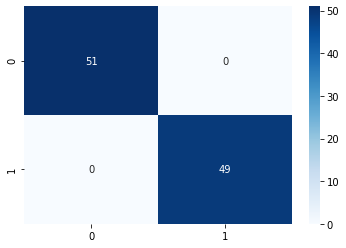

In [127]:
scratch_model = ScratchSVMClassifier(num_iter=100, random_state=0)
train_and_validate(X_train, X_val, y_train, y_val, scratch_model)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



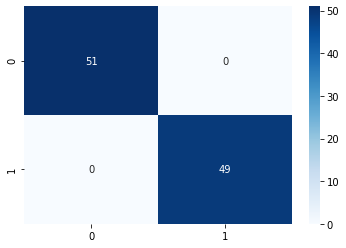

In [128]:
from sklearn.svm import SVC

sklearn_model = SVC(kernel='linear', tol=1e-5, max_iter=100, random_state=0)
train_and_validate(X_train, X_val, y_train, y_val, sklearn_model)

## [Problem 5] Visualization of decision area

In [129]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def decision_region(X, y, model, step=0.01,
                    title="Decision region",
                    xlabel="xlabel",
                    ylabel="ylabel",
                    targets=[0, 1],
                    figsize=(12, 12)):
    # Setting
    scatter_colors = ["red", "blue"]
    contourf_colors = ["pink", "skyblue"]
    n_class = len(targets)

    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, step),
                                   np.arange(np.min(X[:,1]) - 0.5, np.max(X[:,1]) + 0.5, step))
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class - 1, cmap=ListedColormap(contourf_colors))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class - 1, colors='y', alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y == target][:, 0], X[y == target][:, 1],
                    s=80, color=scatter_colors[i], label=targets[i], marker='o')
    plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1],
                color='yellow', s=80, label='support vector')
    patches = [Patch(color=scatter_colors[i], label=targets[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

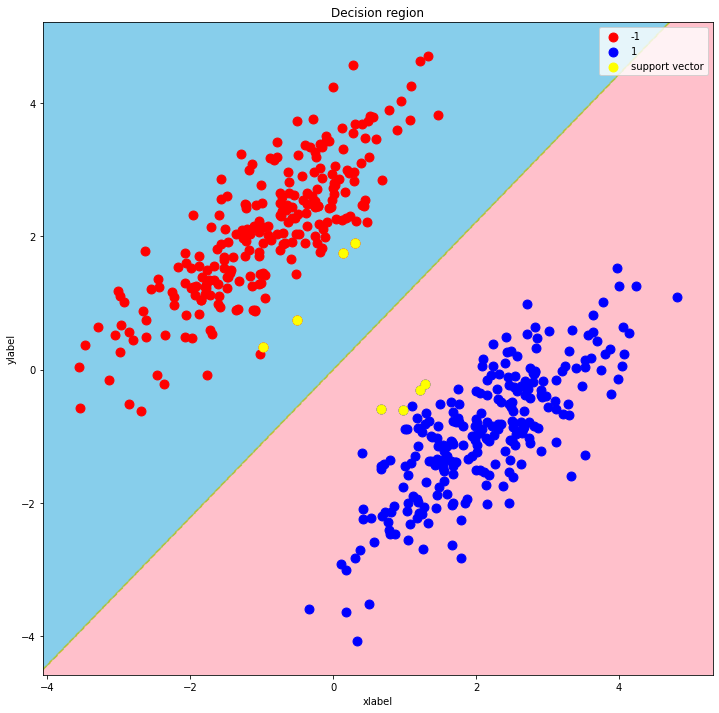

In [130]:
decision_region(X, y, scratch_model, targets=np.unique(y))

## [Problem 6] (Advance task) Creation of polynomial kernel function

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



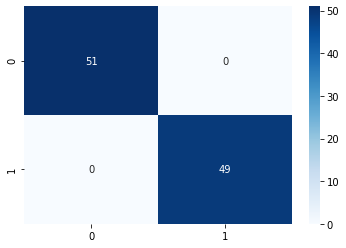

In [131]:
poly_svc = ScratchSVMClassifier(num_iter=100, kernel='poly', degree=2, random_state=0)
train_and_validate(X_train, X_val, y_train, y_val, poly_svc)

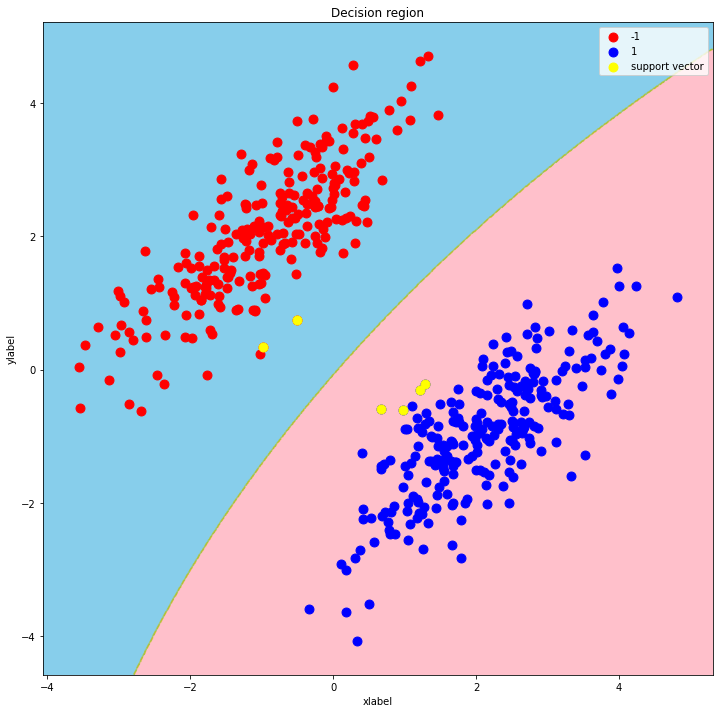

In [132]:
decision_region(X, y, poly_svc, targets=np.unique(y))

### Test with circle as tutorial

In [133]:
n = 300

def generate_circle_points(r, n, label):
    rs = np.random.random(n)
    X = np.c_[r * np.cos(2 * np.pi *rs), r * np.sin(2 * np.pi * rs)]
    y = [label for _ in range(n)]
    return X, y

# Class -1
X1, y1 = generate_circle_points(1., 300, -1)
X2, y2 = generate_circle_points(2., 300, 1)
X = np.r_[X1, X2]
y = np.r_[y1, y2]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        64

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



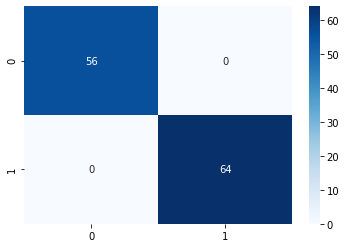

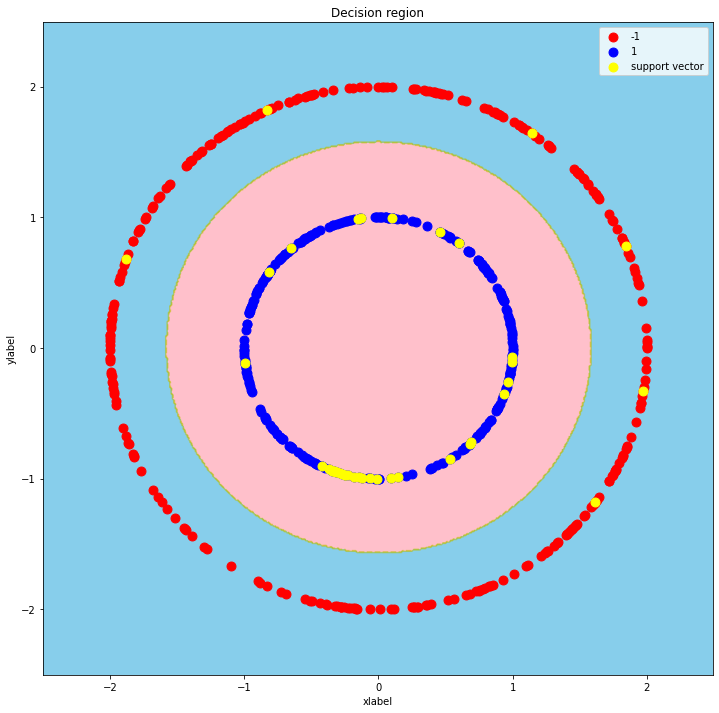

In [134]:
poly_clf = ScratchSVMClassifier(kernel='poly', degree=2, random_state=0)
train_and_validate(X_train, X_val, y_train, y_val, poly_clf)
decision_region(X, y, poly_clf, targets=np.unique(y))